# Footprint Overlap Detector with Polygonal FoV Sensor

Satellite sensor FoV is defined with a **Polygonal** shape within this code. S/C attitude is in **nadir** orientation.

In [1]:
import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

from org.orekit.attitudes import NadirPointing
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.frames import FramesFactory, Transform
from org.orekit.time import TimeScalesFactory, AbsoluteDate
from org.orekit.utils import Constants, IERSConventions
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from org.orekit.models.earth.tessellation import EllipsoidTessellator
from org.orekit.propagation.events import EventDetector, EventsLogger, FootprintOverlapDetector
from org.orekit.propagation.events.handlers import ContinueOnEvent, StopOnEvent
from org.orekit.geometry.fov import PolygonalFieldOfView
from org.orekit.orbits import CartesianOrbit

from org.hipparchus.geometry.euclidean.threed import Vector3D, Line
from org.hipparchus.geometry.euclidean.twod import Vector2D
from org.hipparchus.geometry.spherical.twod import SphericalPolygonsSet, S2Point

import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

from geopy.geocoders import Nominatim

from math import radians, degrees, pi, sqrt, atan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

First call the frames and time scales to be used in the code and create Earth body.

In [2]:
UTC = TimeScalesFactory.getUTC()                               # Define UTC time scale.
ECI = FramesFactory.getEME2000()                               # Define ECI reference frame.
ECEF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)  # Define ECEF reference frame.
TEME = FramesFactory.getTEME()                                 # Define TEME reference frame. 
ITRF = ECEF

R_earth  = Constants.WGS84_EARTH_EQUATORIAL_RADIUS             # Radius of earth
Mu_earth = Constants.WGS84_EARTH_MU                            # Gravitational parameter of earth
f_earth  = Constants.WGS84_EARTH_FLATTENING                    # Earth flattening value

earth = OneAxisEllipsoid(R_earth, f_earth, ITRF)               # Create earth here.

Here, we first take TLE as an input, and from the TLEPropagator we recieve its PV to get Kepler Elements.

In [3]:
# ISS 25544
tle_line1 = "1 25544U 98067A   22257.49623145  .00008872  00000-0  16209-3 0  9998"
tle_line2 = "2 25544  51.6424 254.1285 0002269 232.3655 233.3422 15.50204391359035"
mytle = TLE(tle_line1, tle_line2)

initialDate = mytle.getDate()                    # This is the TLE epoch date read from first line.
finalDate = initialDate.shiftedBy(3600.0 * 24)   # Shift initial date by x hours.

print('Propagation initial date: ', initialDate)
print('Propagation final date: ', finalDate)

satellite_mass = 466615.0                        # Satellite mass [kg]
attitudeProvider = NadirPointing(ECI, earth)     # Also provide attitude of the satellite

SGP4 = TLEPropagator.selectExtrapolator(mytle, attitudeProvider, satellite_mass) 

Propagation initial date:  2022-09-14T11:54:34.39728Z
Propagation final date:  2022-09-15T11:54:34.39728Z


If TLE is used, then we require a proper switch to Kepler Elements. This is done with Algorithm 4.2 from *Orbital Mechanics for Engineering Students, 3rd ed.* by Howard Curtis.

In [4]:
Mu = 398600                                                # Standart grav. parameter (km^3/s^2)
TLE_pv = SGP4.getPVCoordinates(initialDate, ECI)
pos = TLE_pv.getPosition()                                 # Get position vector
vel = TLE_pv.getVelocity()                                 # Get velocity vector
acc = TLE_pv.getAcceleration()                             # Get acceleration vector
pos1 = pos

pos = np.array([pos.getX(), pos.getY(), pos.getZ()])/1000  # Make position an array
vel = np.array([vel.getX(), vel.getY(), vel.getZ()])/1000  # Make velocity an array

pos_mag = sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)          # Find magnitude of position
vel_mag = sqrt(vel[0]**2 + vel[1]**2 + vel[2]**2)          # Find magnitude of velocity
velr= np.dot(vel, pos)/pos_mag                             # Find magnitude Vr

h = np.cross(pos, vel)                                     # Find specific angular momentum vector
h_mag = sqrt(h[0]**2 + h[1]**2 + h[2]**2)                  # Find specific angular momentum magnitude

i = np.arccos(h[2]/h_mag)                                  # Find the inclination (rad)

N = np.cross([0, 0, 1], h)                                 # Find "Node Line" vector
N_mag = sqrt(N[0]**2 + N[1]**2 + N[2]**2)                  # Find "Node Line" magnitude


if N[1]>=0:
    raan = np.arccos(N[0]/N_mag)                           # Find RAAN with this IF block
else:
    raan = radians(360 - degrees(np.arccos(N[0]/N_mag)))

e = (1/Mu)*((vel_mag**2-Mu/pos_mag)*pos-pos_mag*velr*vel)  # Find eccentricity vector
e_mag = sqrt(np.dot(e,e))                                  # Find eccentricity magnitude

if e[2]>=0:
    aop = np.arccos(np.dot(N,e)/(N_mag*e_mag))             # Find Argument of Perigee with this block
else:
    aop = radians(360 - degrees(np.arccos(np.dot(N,e)/(N_mag*e_mag))))
    
if velr>=0:
    ta = np.arccos(np.dot(e,pos)/(e_mag*pos_mag))          # Find True Anomaly with this IF block
else:
    ta = radians(360 - degrees(np.arccos(np.dot(e,pos)/(e_mag*pos_mag))))
    
a  = (h_mag**2/Mu)*(1/(1 - e_mag**2))*1000                 # Find Semimajor Axis in meters.

a = float(a)
e_mag = float(e_mag)
i = float(i)
aop = float(aop)
raan = float(raan)
ta = float(ta)

ra = a*(e_mag + 1)/1000                                    # Find the apoapsis value in km.  
ra = float(ra)

In the following parts, we are going to create either a defined geographical zone or a custom zone from lat/long coordinates.

### Creating the Region-of-Interest

In the below part, first the region of interest should be selected. These region data is available in three resolutions: 110m, 50m, and 10m.

Also, the region in interest may be constituted of several pieces. If that is the case *GeodeticPoint* sets can be increased to include extra land masses. The region is also plotted in this step.

With the gathered *GeodeticPoint* sets, region(s) are then created with *EllipsoidTesselator* method to be used.

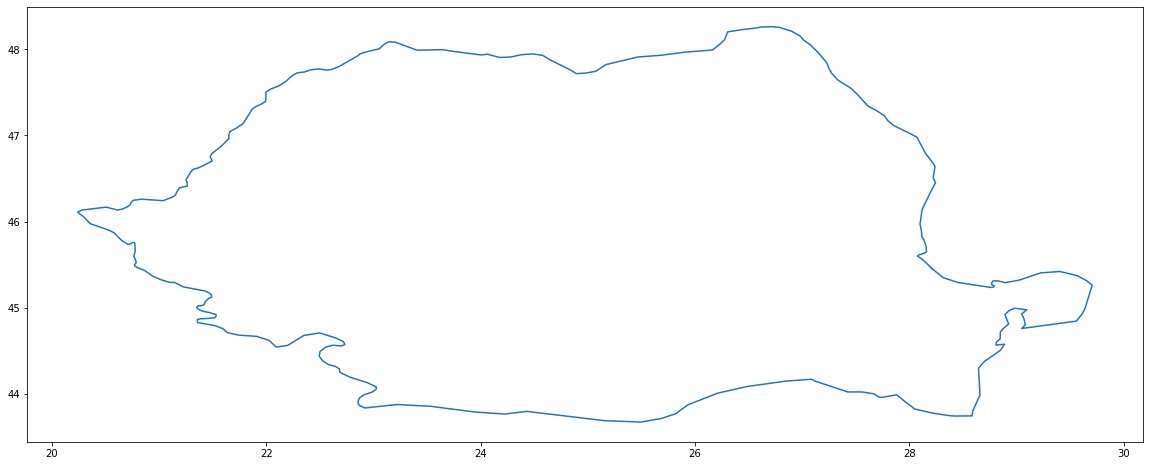

In [5]:
# Region-Of-Interest Specification
region_of_interest = 'Romania'
region_colour = 'b'

# Get Region-Of-Interest Polygon - Available Resolutions: 110m, 50m, and 10m
resolution = 50
shpfilename = shpreader.natural_earth(resolution=str(resolution)+'m',
                                      category='cultural', 
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
country_geometry = pd.DataFrame()

for country in countries:
    if country.attributes['NAME'] == region_of_interest:
        country_geometry = country.geometry

# List of Geographical Coordinates of the Polygon vertices
longitude0, latitude0 = country_geometry.exterior.coords.xy # enter index to get different parts of Turkey

# Prepare latitude and longitude to specify Region-Of-Interest Polygon
latitude0.reverse()
longitude0.reverse()

# Create Geodetic Points0 for first zone
geodeticPoints0 = []
for lon0, lat0 in zip(longitude0, latitude0):
    geodeticPoints0.append(GeodeticPoint(radians(lat0), radians(lon0), 0.0))

# Plotting the region-of-interest    
fig = plt.figure("Country")
fig.set_figwidth(20)
fig.set_figheight(8)
plt.figure(1) 
plt.plot(longitude0,latitude0)  # longitude0,latitude0,longitude1,latitude1
plt.show()    
    
# Build Regions of Interest as Polygons
hyperplaneThickness = 1.0e-10
region_polygon0 = EllipsoidTessellator.buildSimpleZone(hyperplaneThickness, geodeticPoints0)

# Angular Margin [rad]
angular_margin = radians(0.0)

Defining Polygon FoV shape of the s/c and creating *FootprintOverlapDetector* method. Finally the event detector must be added to propagator for monitoring.

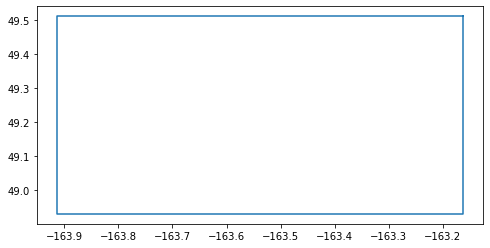

In [9]:
# Create a simple Polygon Field-Of-View for Satellite sensor
fovpattern = [(49.5122, -163.1627), (49.5122, -163.9141), (48.9301, -163.9141), 
           (48.9301, -163.1627), (49.5122, -163.1627)] #lat-lon version

#pattern = [(291.0592, 83.5803), (217.8847, 84.1174), (111.5916, 84.9681), 
#           (23.5558, 84.3395), (-68.9408, 83.5803)]  #az-el version

geodeticPoints3 = []
for lat3, lon3 in fovpattern:
    geodeticPoints3.append(GeodeticPoint(radians(lat3), radians(lon3), 0.0))

fov_polygon = EllipsoidTessellator.buildSimpleZone(hyperplaneThickness, geodeticPoints3)

fovpattern = list(fovpattern)
lat4 = [x for x,y in fovpattern]
lon4 = [y for x,y in fovpattern]

# Plotting the region-of-interest
fig = plt.figure("FoV")
fig.set_figwidth(8)
fig.set_figheight(4)
plt.figure(1)
plt.plot((lon4),(lat4))
plt.show()

fov_margin = 0.0
#imagerFOV1 = PolygonalFieldOfView(Vector3D.PLUS_K, PolygonalFieldOfView.DefiningConeType.OUTSIDE_CONE_TOUCHING_POLYGON_AT_VERTICES,Vector3D.PLUS_I,radians(3.0), 6, 0.0)
imagerFOV1 = PolygonalFieldOfView(fov_polygon, fov_margin)

sampling_step = 1000.0

# Define FootprintOverlapDetector and add it to the propagator
FPODetector = FootprintOverlapDetector(imagerFOV1, earth, 
                                        region_polygon0, 
                                        sampling_step).withHandler(ContinueOnEvent())
# Get the logger for events.
FPO_logger = EventsLogger()

# Add the detector to the SGP4 propagator
SGP4.addEventDetector(FPO_logger.monitorDetector(FPODetector))

Now start propagating the TLE with SGP4. Here, propagation interval has to be sufficiently small because if it is large, detectors may miss certain events.

In [10]:
pos = []                                                       # position vector array to be filled.
footPrintList = []

initialDate = mytle.getDate()
###Start SGP4 propagation from initialDate up until finalDate
while (initialDate.compareTo(finalDate) <= 0.0):
    SGP4_pv = SGP4.getPVCoordinates(initialDate, ECI)          # Get PV coordinates
    posSGP4 = SGP4_pv.getPosition()                            # But we only want position vector.
    pos.append((posSGP4.getX(),posSGP4.getY(),posSGP4.getZ())) # Get individual elements of position
    posSGP4 = pos
    
    initialCartesianOrbit = CartesianOrbit(SGP4_pv, ECI, initialDate, Mu_earth)
    state = SpacecraftState(initialCartesianOrbit, satellite_mass)
    inertToBody = state.getFrame().getTransformTo(earth.getBodyFrame(), state.getDate())
    fovToBody = Transform(state.getDate(), state.toTransform().getInverse(), inertToBody)
    footprint = imagerFOV1.getFootprint(fovToBody, earth, radians(10.0))
    footPrintList.append(footprint)
    
    initialDate = initialDate.shiftedBy(60.0)                  # Propagate with 60 sec intervals.

In [13]:
print(footPrintList[0])

[[{lat: 51.0167871854 deg, lon: -167.9148652111 deg, alt: 0}, {lat: 51.0538681145 deg, lon: -167.8782655044 deg, alt: 0}, {lat: 51.0930459078 deg, lon: -167.9762557517 deg, alt: 0}, {lat: 51.0551197837 deg, lon: -168.0136047664 deg, alt: 0}]]


Finally the logged events are retrieved and printed in a readable way.

In [12]:
FPO_events = FPO_logger.getLoggedEvents()
print('\n\nTotal of', int(FPO_events.size()/2), 'events detected.')
print('\033[1m' + "\nSatellite Entrace"+" "*22+"Satellite Exit"+" "*24+"Duration" + '\033[0m')
FPO_entry = None 
for event in FPO_logger.getLoggedEvents(): 
    if not event.isIncreasing():
        FPO_entry = event.getState().getDate()
        FPO_giris = str(FPO_entry)
    elif FPO_entry:
        FPO_exit = event.getState().getDate()
        FPO_cikis = str(FPO_exit)
        FPO_duration = FPO_exit.durationFrom(FPO_entry)/60
        FPO_entry = None
        print(FPO_giris,"  ", FPO_cikis, "  ", FPO_duration)



Total of 1 events detected.

Satellite Entrace                      Satellite Exit                        Duration
2022-09-15T00:20:29.22745346404095Z    2022-09-15T00:21:43.31162257326599Z    1.2347361518204174
